In [48]:
import pandas as pd
import matplotlib as plt

from surprise import SVD, SlopeOne
from surprise import NormalPredictor

from surprise import Dataset
from surprise import Reader

from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

from helpers import *

In [7]:
data = load_data("data/data_train.csv")
data.head()

,user,movie,rating
0,r44,c1,4
1,r61,c1,3
2,r67,c1,4
3,r72,c1,3
4,r86,c1,5


In [8]:
dataset = Dataset.load_from_df(data[['user', 'movie', 'rating']], Reader(rating_scale=(1, 5)))

In [9]:
param_grid = {'n_epochs': [5, 40], 'lr_all': [0.0005, 0.005], 'reg_all': [0.1, 0.6]}
# param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(dataset)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.000324679425072
{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}


In [10]:
algo = gs.best_estimator['rmse']
# Run 5-fold cross-validation and print results.
cross_validate(algo, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9995  0.9977  0.9983  0.9993  0.9974  0.9984  0.0009  
MAE (testset)     0.8150  0.8125  0.8130  0.8142  0.8123  0.8134  0.0010  
Fit time          114.04  114.39  114.18  114.39  114.25  114.25  0.13    
Test time         2.35    2.56    2.57    2.55    2.81    2.57    0.15    


{'test_rmse': array([0.99949775, 0.9976783 , 0.99826148, 0.99932661, 0.99735831]),
 'test_mae': array([0.81495427, 0.81252993, 0.81299989, 0.81419226, 0.81228018]),
 'fit_time': (114.04352903366089,
  114.38591384887695,
  114.18455100059509,
  114.38810396194458,
  114.24767208099365),
 'test_time': (2.3540360927581787,
  2.5599582195281982,
  2.5708980560302734,
  2.5545918941497803,
  2.812614917755127)}

In [11]:
gen_submission(r'data/submission_svd_gridsearch.csv', algo)

In [13]:
algo2 = SlopeOne()
cross_validate(algo2, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9988  1.0004  1.0004  0.9993  1.0021  1.0002  0.0011  
MAE (testset)     0.7998  0.8016  0.8028  0.8014  0.8031  0.8017  0.0012  
Fit time          6.89    6.76    7.57    8.03    7.49    7.35    0.47    
Test time         30.87   35.14   37.20   35.44   34.70   34.67   2.08    


{'test_rmse': array([0.99883368, 1.00037476, 1.0004452 , 0.99932666, 1.00207816]),
 'test_mae': array([0.79976723, 0.80158214, 0.80280061, 0.80137969, 0.80308443]),
 'fit_time': (6.893857002258301,
  6.7554309368133545,
  7.5669920444488525,
  8.032685995101929,
  7.491451978683472),
 'test_time': (30.872541904449463,
  35.13552212715149,
  37.19649386405945,
  35.44131135940552,
  34.703794956207275)}

In [26]:
def pick_determined(a, b):
    frac_a = abs(a - round(a))
    frac_b = abs(b - round(b))
    if abs(frac_a - 0.5) > abs(frac_b - 0.5):
        return int(round(a))
    else:
        return int(round(b))

In [27]:
submission2 = pd.read_csv("data/sample_submission.csv")
submission2['Prediction'] = [pick_determined(algo.predict(user, movie).est, algo2.predict(user, movie).est) for [user, movie] in submission2['Id'].str.split('_')]
submission2.to_csv(r'data/sub_svd_slopeone_det.csv', index=False)

In [37]:
data["SVD"] = data.apply(lambda x: abs(algo.predict(x.user, x.movie).est - x.rating), axis=1)

In [38]:
data["SlopeOne"] = data.apply(lambda x: abs(algo2.predict(x.user, x.movie).est - x.rating), axis=1)

In [45]:
data["SVD"].mean()

0.7953084296606299

In [46]:
data["SlopeOne"].mean()

0.7901176937791015

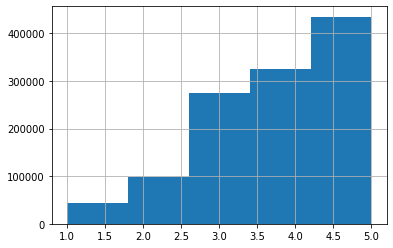

In [50]:
data["rating"].hist(bins = 5)